## Bank Note Forgery Analysis with Tensorflow

This analysis uses the [Bank Authentication Data Set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) from the UCI repository.

The data consists of 5 columns:

* variance of Wavelet Transformed image (continuous)
* skewness of Wavelet Transformed image (continuous)
* curtosis of Wavelet Transformed image (continuous)
* entropy of image (continuous)
* class (integer)

Where class indicates whether or not a Bank Note was authentic.

In [22]:
# imports
# this is from an older version of tf. Switching to compat mode to make it functional
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default. 
sns.set_style("darkgrid") # set a grey grid as a background
# quell warnings
import warnings
warnings.filterwarnings('ignore')
# ML imports
import sklearn
from sklearn import metrics
# Linear Regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Logistic Regression
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

W0828 14:06:28.626250 4484150720 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


#### Importing data

In [23]:
df = pd.read_csv('bank_note_data.csv')

### EDA

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
Image.Var     1372 non-null float64
Image.Skew    1372 non-null float64
Image.Curt    1372 non-null float64
Entropy       1372 non-null float64
Class         1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [56]:
df.head(3)

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [57]:
df.corr()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
Image.Var,1.000000,0.264026,-0.380850,0.276817,-0.724843
Image.Skew,0.264026,1.000000,-0.786895,-0.526321,-0.444688
Image.Curt,-0.380850,-0.786895,1.000000,0.318841,0.155883
Entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
Class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


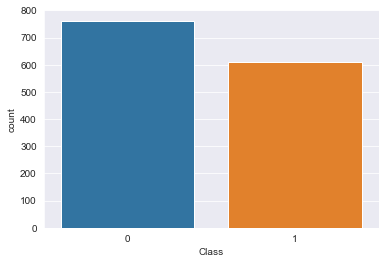

In [26]:
#Creating a Countplot of the Classes (Authentic 1 vs Fake 0)
sns.countplot(x='Class',data=df)

In [27]:
# test of resetting class type as a boolean
df1 = df.copy()

In [28]:
df1['Class'] = df1['Class'].astype(dtype='bool')

In [54]:
df1['Class'][:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: Class, dtype: bool

#### Create a PairPlot of the Data with Seaborn, set Hue to Class 

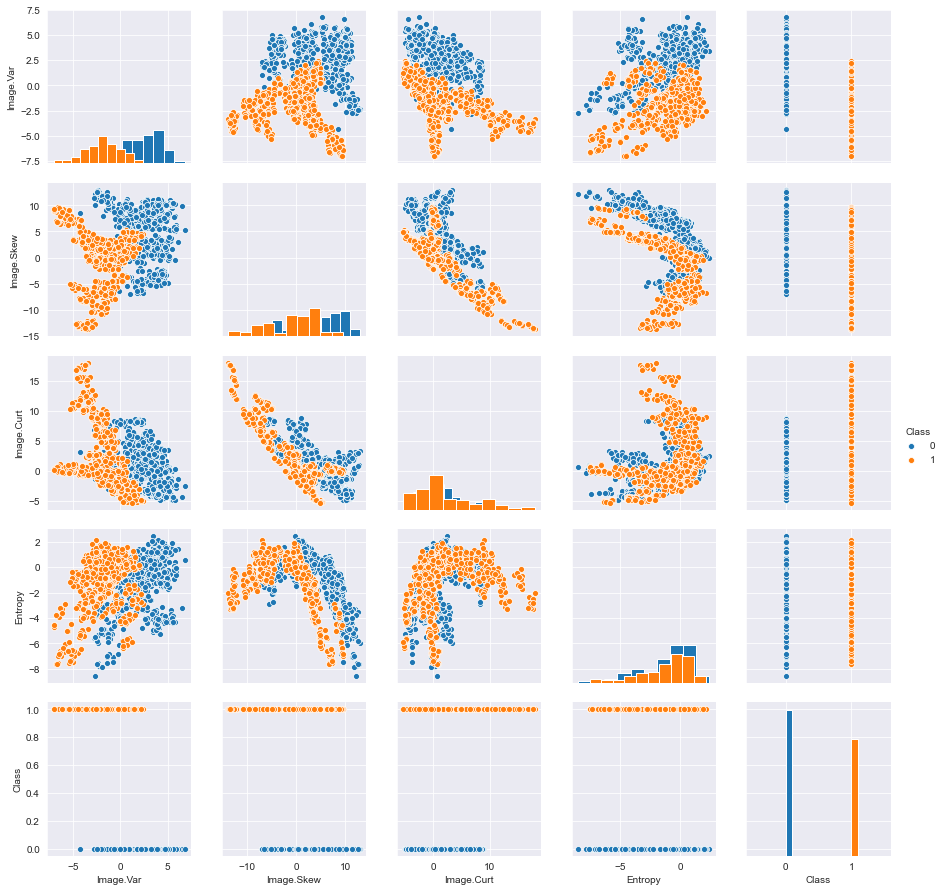

In [30]:
sns.pairplot(df,hue='Class',diag_kind='hist')

## Data Preparation 

Standardizing the data for the Neural Net

### Standard Scaling



**Create a StandardScaler() object called scaler.**

In [31]:
scaler = StandardScaler()

**Fit scaler to the features.**

In [32]:
scaler.fit(df.drop('Class',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

**Use the .transform() method to transform the features to a scaled version.**

In [33]:
scaled_features = scaler.fit_transform(df.drop('Class',axis=1))

In [34]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])

In [35]:
df_feat.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587


**Convert the scaled features to a dataframe and check the head of this dataframe to make sure the scaling worked.**

In [36]:
df_feat.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587


### Train Test Split

**Creating two objects X and y which are the scaled feature values and labels respectively.**

In [37]:
# Target - what we want to predict
y = df['Class']
# Features - what we use to make the prediction
X = df.drop('Class',axis=1)

In [38]:
# The Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Tensorflow Analysis

**Creating a list of feature column objects using tf.feature.numeric_column()**

In [39]:
feat_cols = []
for col in X.columns:
    feat_cols.append(tf.feature_column.numeric_column(col))

In [40]:
feat_cols

[NumericColumn(key='Image.Var', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Image.Skew', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Image.Curt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Entropy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

**Creating an object called classifier which is a DNNClassifier. It will have 2 classes and a [10,20,10] hidden unit layer structure:**

In [41]:
classifier = tf.estimator.DNNClassifier(hidden_units=[10,20,10], n_classes=2, feature_columns=feat_cols)

W0828 14:06:40.516192 4484150720 estimator.py:1846] Using temporary folder as model directory: /var/folders/y7/npvsnnsx4fb77q7hsmzg0rn80000gn/T/tmpb0ohuymh


**Creating a tf.estimator.pandas_input_fn that takes in your X_train, y_train, batch_size and set shuffle=True.**

In [42]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=5,shuffle=True)

**Train classifier to the input function using steps=500.**

In [43]:
classifier.train(input_fn=input_func,steps=500)

W0828 14:06:40.536060 4484150720 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0828 14:06:40.549963 4484150720 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:65: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0828 14:06:40.551623 4484150720 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_functions.py:491: add_queue_runner (f

## Model Evaluation

**Creating another pandas_input_fn that takes in the X_test data for x. This one won't need any y_test info since we will be using this for the network to create its own predictions. Set shuffle=False since we don't need to shuffle for predictions.**

In [44]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)

** Use the predict method from the classifier model to create predictions from X_test **

In [45]:
predictions = list(classifier.predict(input_fn=pred_fn))

In [46]:
predictions[1]

{'logits': array([-7.6203856], dtype=float32),
 'logistic': array([0.0004901], dtype=float32),
 'probabilities': array([9.9950993e-01, 4.9011240e-04], dtype=float32),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object)}

In [47]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

**The classification report and a Confusion Matrix**

The output data is abnormally correct. It would make sense to compare this to another model to see if something has gone wrong.

In [48]:
print(confusion_matrix(y_test,final_preds))
print(classification_report(y_test,final_preds))

[[229   0]
 [  0 183]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       183

   micro avg       1.00      1.00      1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



### Compare the output to a Random Forest Classifier 

This is a chance to use a different classifier to bolster our sense of reality

In [49]:
# import model
from sklearn.tree import DecisionTreeClassifier

In [50]:
# Create an instance of the DecisionTreeClassifier object
dtree = DecisionTreeClassifier()

In [51]:
# Fit the Data
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
# Make predictions
predictions = dtree.predict(X_test)

In [55]:
# Printing results
# This also looks really close to our original, adding confidence to the process
#
print('Classification Report')
print(classification_report(y_test,predictions))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       229
           1       1.00      0.97      0.98       183

   micro avg       0.99      0.99      0.99       412
   macro avg       0.99      0.98      0.99       412
weighted avg       0.99      0.99      0.99       412



Confusion Matrix
[[229   0]
 [  6 177]]
